<a href="https://colab.research.google.com/github/panzershracker/Deep-learning-in-comp.-vision/blob/master/HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Евдокимов Алексей.

# Задание 

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [197]:
%tensorflow_version 2.x

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.manifold import TSNE

import tensorflow_datasets as tfds

In [199]:
tf.__version__

'2.2.0'

In [200]:
load = 1

In [201]:
if load:
  (df_train, df_test), df_info = tfds.load(
      'lfw',
      as_supervised=True,
      with_info=True,
      split=['train[:90%]', 'train[90%:]']
  )

In [202]:
df_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

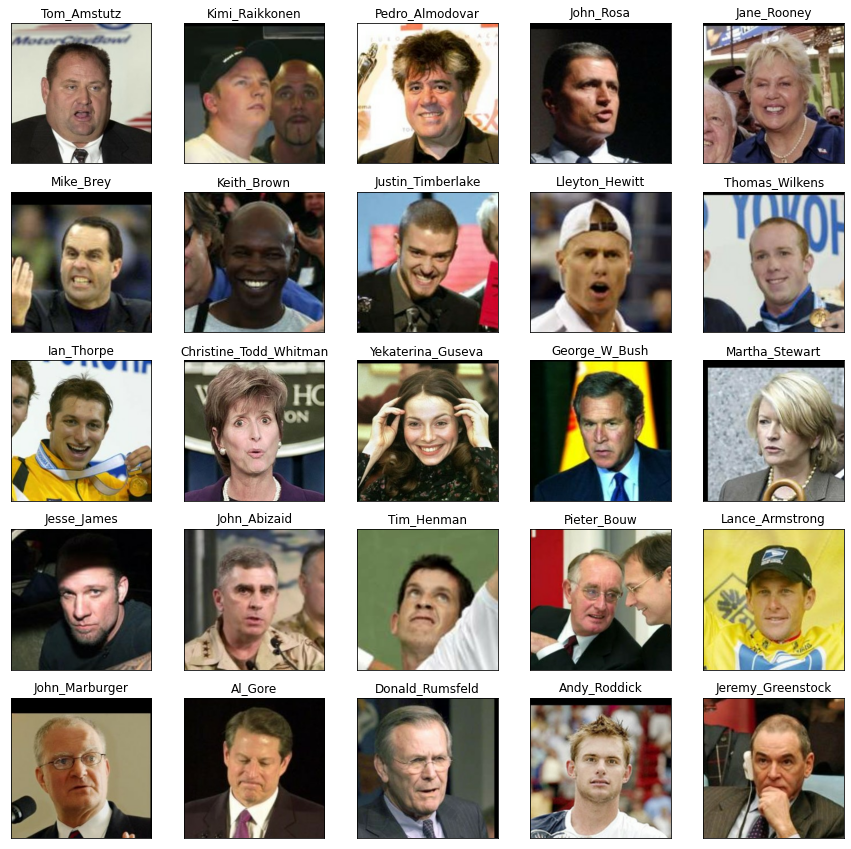

In [203]:
samples = [[x[0], x[1]] for x in iter(df_train.take(25))]

fig = plt.figure(figsize=(15,15))

for i in range(len(samples)):
  ax = fig.add_subplot(5,5, i+1)
  ax.set_title(samples[i][0].numpy().decode('UTF-8'))
  ax.imshow(samples[i][1])
  plt.xticks([]), plt.yticks([])

plt.show()

In [204]:
def df_len(df):
  return len([[id,x] for x in enumerate(df)])

In [205]:
df_len(df_train), df_len(df_test)

(11910, 1323)

In [206]:
# Normalization

def normalization(label, image):
  return label, tf.cast(image, tf.float32) / 255

# Создание модели

In [207]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2,2), (2,2)),
        tf.keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2,2), (2,2)),
        tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(EMB_SIZE, activation=None)
])

# Contrastive loss

In [208]:
MARGIN= 10

def contrast_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

# Pipeline

In [209]:
BATCH = 64
EPOCH = 30

df_train = df_train.map(normalization)
df_train = df_train.shuffle(buffer_size=1000)
df_train = df_train.repeat(EPOCH)
df_train = df_train.batch(BATCH)

In [210]:
# Optimizer

LEARNING_RATE = 0.0005

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Обучение модели

In [211]:
%%time 

for i, (labels, images) in enumerate(df_train):

  #forward
  with tf.GradientTape() as tape:
    embs = model(images)
    loss = contrast_loss(embs, labels)

  #backward
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))

  if i % 50 == 0:
    print(f'[{i}] Loss = {loss.numpy()}')

[0] Loss = 96.4378433227539
[50] Loss = 20.774660110473633
[100] Loss = 0.3261691629886627
[150] Loss = 0.06855999678373337
[200] Loss = 8.318792343139648
[250] Loss = 6.654932022094727
[300] Loss = 8.124722480773926
[350] Loss = 0.0
[400] Loss = 0.1787569224834442
[450] Loss = 0.0
[500] Loss = 0.0
[550] Loss = 0.903032660484314
[600] Loss = 0.8164956569671631
[650] Loss = 0.0
[700] Loss = 0.0
[750] Loss = 0.0
[800] Loss = 0.0
[850] Loss = 0.21210847795009613
[900] Loss = 0.0
[950] Loss = 0.2407280057668686
[1000] Loss = 0.0
[1050] Loss = 2.3119144439697266
[1100] Loss = 0.0
[1150] Loss = 0.36310845613479614
[1200] Loss = 0.6027390360832214
[1250] Loss = 0.0
[1300] Loss = 0.0
[1350] Loss = 0.0
[1400] Loss = 0.08052237331867218
[1450] Loss = 0.0
[1500] Loss = 0.0
[1550] Loss = 0.0
[1600] Loss = 0.0
[1650] Loss = 0.0
[1700] Loss = 0.020091857761144638
[1750] Loss = 0.0
[1800] Loss = 0.31536567211151123
[1850] Loss = 1.7216475498571526e-06
[1900] Loss = 0.26277774572372437
[1950] Loss = 0

# Получение эмбеддингов новых фото

In [226]:
!wget https://thumbs.dfs.ivi.ru/storage38/contents/2/6/4935009ca8d5d1e61b3277c76ea06c.jpg
!wget https://images.alphacoders.com/875/875365.jpg
!wget https://img.tyt.by/620x620s/n/afisha/03/8/o_konchita_1_.jpg

--2020-06-17 14:48:13--  https://thumbs.dfs.ivi.ru/storage38/contents/2/6/4935009ca8d5d1e61b3277c76ea06c.jpg
Resolving thumbs.dfs.ivi.ru (thumbs.dfs.ivi.ru)... 91.233.218.125, 91.233.218.127, 91.233.218.124, ...
Connecting to thumbs.dfs.ivi.ru (thumbs.dfs.ivi.ru)|91.233.218.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘4935009ca8d5d1e61b3277c76ea06c.jpg.3’

4935009ca8d5d1e61b3     [ <=>                ]  36.56K  --.-KB/s    in 0s      

2020-06-17 14:48:15 (269 MB/s) - ‘4935009ca8d5d1e61b3277c76ea06c.jpg.3’ saved [37436]

--2020-06-17 14:48:16--  https://images.alphacoders.com/875/875365.jpg
Resolving images.alphacoders.com (images.alphacoders.com)... 104.20.14.194, 172.67.3.36, 104.20.15.194, ...
Connecting to images.alphacoders.com (images.alphacoders.com)|104.20.14.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 795683 (777K) [image/jpeg]
Saving to: ‘875365.jpg’

875365.jpg          10

In [227]:
import imageio
from skimage.transform import resize

In [228]:
def prepare_img(img_name):
  img = imageio.imread(img_name, pilmode='RGB')
  img = img.astype(np.float32) / 255
  img = resize(img, (250, 250, 3), mode='reflect')
  img = np.reshape(img, (250, 250, 3))

  return img

In [229]:
img_1 = prepare_img('4935009ca8d5d1e61b3277c76ea06c.jpg') # woman
img_2 = prepare_img('875365.jpg') # woman
img_3 = prepare_img('o_konchita_1_.jpg') # not woman

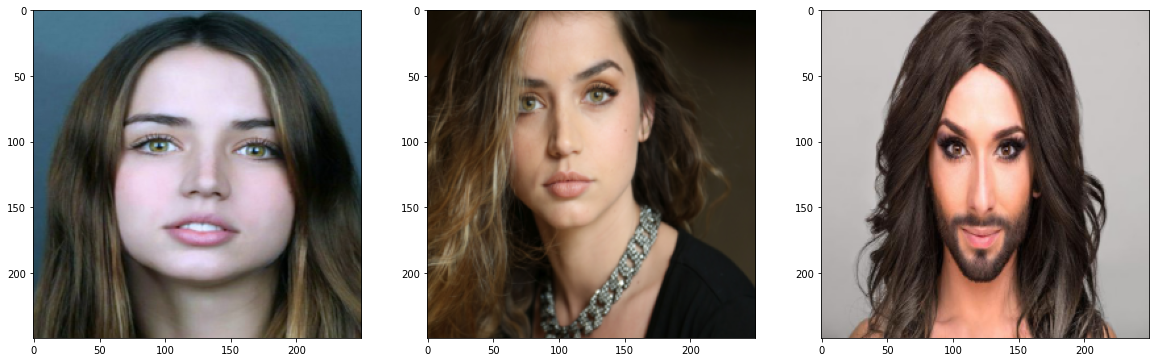

In [230]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_1)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_2)

ax = fig.add_subplot(1,3,3)
ax.imshow(img_3)

In [231]:
new_embs = model(np.stack((img_1, img_2, img_3), axis=0))

In [232]:
def diff(e1, e2):
  return np.sqrt(np.sum((e1 - e2)**2))

# Вычисление расстояния между новыми эмбеддингами

In [233]:
emb_1 = new_embs[0,:]
emb_2 = new_embs[1,:]
emb_3 = new_embs[2,:]

print(f'woman_1 <-> woman_2 = {diff(emb_1, emb_2)}')
print(f'woman_1 <-> not woman = {diff(emb_1, emb_3)}')
print(f'woman_2 <-> not woman = {diff(emb_2, emb_3)}')


woman_1 <-> woman_2 = 7.699785232543945
woman_1 <-> not woman = 27.39328384399414
woman_2 <-> not woman = 25.578466415405273
